This notebook aims to solve a practice problem [Twitter Sentiment Analysis](https://datahack.analyticsvidhya.com/contest/practice-problem-twitter-sentiment-analysis/#About) hosted by Analytics Vidhya.

# Problem Statement
The objective of this project is to detect hate speech in tweets. For the sake of simplicity, we say a tweet contains hate speech if it has a racist or sexist sentiment associated with it. So, the task is to classify racist or sexist tweets from other tweets.<br>

Formally, given a training sample of tweets and labels, where label '1' denotes the tweet is racist/sexist and label '0' denotes the tweet is not racist/sexist, your objective is to predict the labels on the test dataset.

# Data

train.csv - For training the models, we have a labelled dataset of 31,962 tweets. The dataset is provided in the form of a csv file with each line storing a tweet id, its label and the tweet.

test_tweets.csv - The test data file contains only tweet ids and the tweet text with each tweet in a new line.

# Agenda
1. Data Loading
2. Feature Engineering
3. Data Preprocessing
    * Text Normalization
    * Vectorization
    * SMOTE
4. ML Modeling
5. Hyperparameter Tuning
6. Prediction Submission

# Importing Necessary Libraries

In [1]:
# Data Analysis
import pandas as pd
import numpy as np

# Data Visualization
from matplotlib import pyplot as plt
import seaborn as sns

# Machine Learning
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# NLP
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from wordcloud import WordCloud, STOPWORDS
import re

# Warning
import warnings
warnings.filterwarnings('ignore')

# Data Loading

In [2]:
# Loading train data
train_df = pd.read_csv('train_E6oV3lV.csv')
print(f'Train data shape: {train_df.shape}')
train_df.head()

Train data shape: (31962, 3)


,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation


In [3]:
# Loading test data
test_df = pd.read_csv('test_tweets_anuFYb8.csv')
print(f'Test data shape: {test_df.shape}')
test_df.head()

Test data shape: (17197, 2)


,id,tweet
0,31963,#studiolife #aislife #requires #passion #dedic...
1,31964,@user #white #supremacists want everyone to s...
2,31965,safe ways to heal your #acne!! #altwaystohe...
3,31966,is the hp and the cursed child book up for res...
4,31967,"3rd #bihday to my amazing, hilarious #nephew..."


In [4]:
# Duplicates check
train_df.duplicated().sum()

0

There are no duplicate records.

In [5]:
# Data types check
train_df.dtypes

id        int64
label     int64
tweet    object
dtype: object

The data type of each feature is appropriate.

In [6]:
# Missing values check
print(f'Missing values in train data:\n{train_df.isnull().sum()}')
print('-'*40)
print(f'Missing values in test data:\n{test_df.isnull().sum()}')

Missing values in train data:
id       0
label    0
tweet    0
dtype: int64
----------------------------------------
Missing values in test data:
id       0
tweet    0
dtype: int64


There are no missing values in the train and test data.

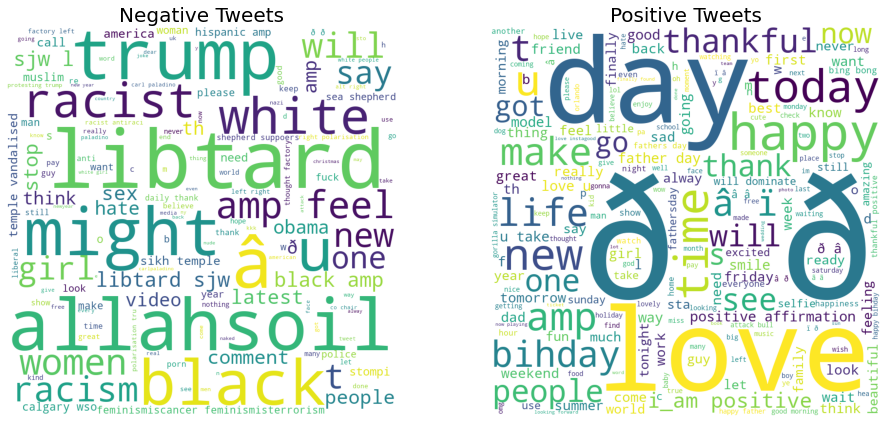

In [7]:
# Plotting wordclouds for both negative and positive tweets
stopwords = set(STOPWORDS)

# Removing 'user' word as it does not hold any importance in our context
stopwords.add('user')        

negative_tweets = train_df['tweet'][train_df['label']==1].to_string()
wordcloud_negative = WordCloud(width = 800, height = 800, 
                               background_color ='white', stopwords = stopwords,
                               min_font_size = 10).generate(negative_tweets)

positive_tweets = train_df['tweet'][train_df['label']==0].to_string()
wordcloud_positive = WordCloud(width = 800, height = 800, 
                               background_color ='white', stopwords = stopwords,
                               min_font_size = 10).generate(positive_tweets)
 
# Plotting the WordCloud images                     
plt.figure(figsize=(14, 6), facecolor = None)

plt.subplot(1, 2, 1)
plt.imshow(wordcloud_negative)
plt.axis("off")
plt.title('Negative Tweets', fontdict={'fontsize': 20})

plt.subplot(1, 2, 2)
plt.imshow(wordcloud_positive)
plt.axis("off")
plt.title('Positive Tweets', fontdict={'fontsize': 20})

plt.tight_layout() 
plt.show()

# Feature Engineering
We'll try to extract a few characteristics of the tweets to help us separate negative tweets from positive ones.

In [8]:
# Feature Engineering
train_df_fe = train_df.copy()
train_df_fe['tweet_length'] = train_df_fe['tweet'].str.len()
train_df_fe['num_hashtags'] = train_df_fe['tweet'].str.count('#')
train_df_fe['num_exclamation_marks'] = train_df_fe['tweet'].str.count('\!')
train_df_fe['num_question_marks'] = train_df_fe['tweet'].str.count('\?')
train_df_fe['total_tags'] = train_df_fe['tweet'].str.count('@')
train_df_fe['num_punctuations'] = train_df_fe['tweet'].str.count('[.,:;]')
train_df_fe['num_question_marks'] = train_df_fe['tweet'].str.count('[*&$%]')
train_df_fe['num_words'] = train_df_fe['tweet'].apply(lambda x: len(x.split()))
train_df_fe.head()

,id,label,tweet,tweet_length,num_hashtags,num_exclamation_marks,num_question_marks,total_tags,num_punctuations,num_words
0,1,0,@user when a father is dysfunctional and is s...,102,1,0,0,1,1,18
1,2,0,@user @user thanks for #lyft credit i can't us...,122,3,0,0,2,1,19
2,3,0,bihday your majesty,21,0,0,0,0,0,3
3,4,0,#model i love u take with u all the time in ...,86,1,3,0,0,0,14
4,5,0,factsguide: society now #motivation,39,1,0,0,0,1,4


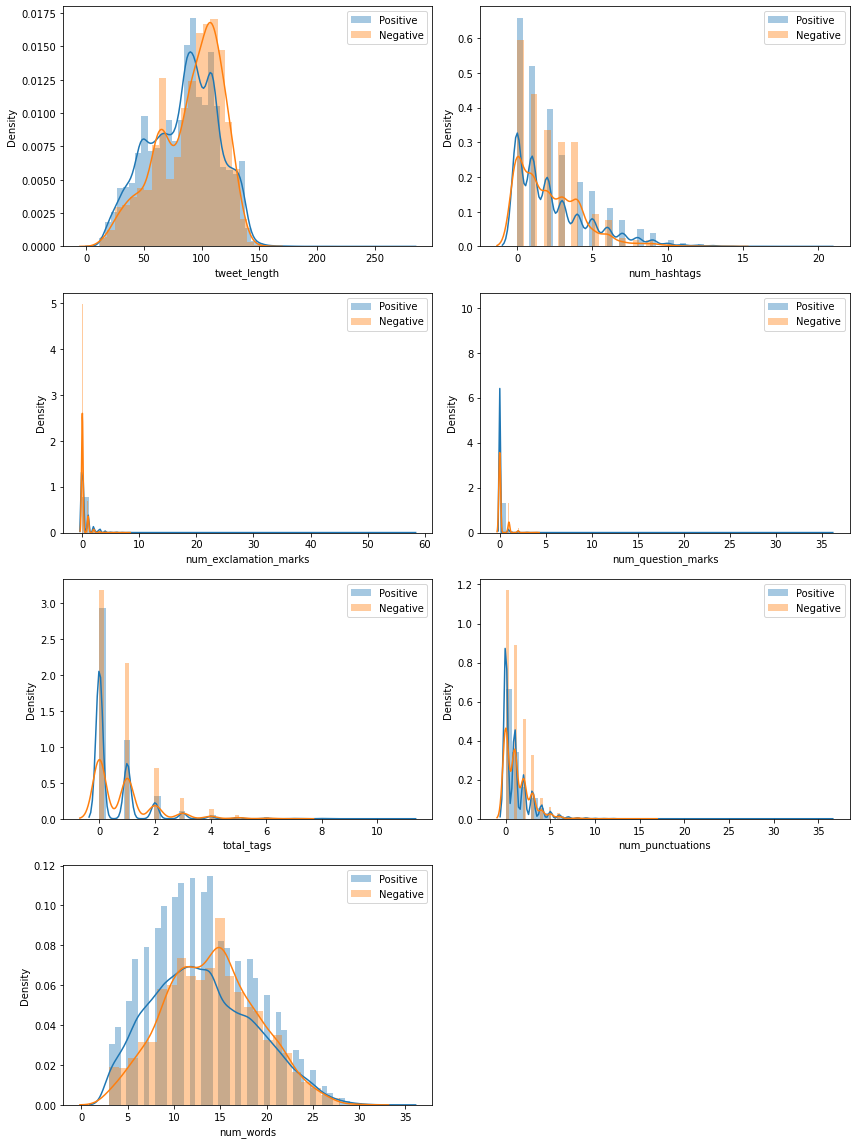

In [9]:
# Visualizing relationship of newly created features with the tweet sentiments
plt.figure(figsize=(12, 16))
features = ['tweet_length', 'num_hashtags', 'num_exclamation_marks', 'num_question_marks', 
            'total_tags', 'num_punctuations', 'num_words']
for i in range(len(features)):
    plt.subplot(4, 2, i+1)
    sns.distplot(train_df_fe[train_df_fe.label==0][features[i]], label = 'Positive')
    sns.distplot(train_df_fe[train_df_fe.label==1][features[i]], label = 'Negative')
    plt.legend()
plt.tight_layout()
plt.show()

The above plots signify that the engineered features cannot considerably separate negative tweets from positive ones. I tried to incorporate these features in our final model for predicting sentiments of the tweets, but it decreased the performance instead of improving. Therefore, I have not included these features ahead in this notebook.
# Data Preprocessing

In [10]:
# Train-Test Splitting
X = train_df.drop(columns=['label'])
y = train_df['label']
test = test_df
print(X.shape, test.shape, y.shape)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=8)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(31962, 2) (17197, 2) (31962,)
(25569, 2) (6393, 2) (25569,) (6393,)


## Text Normalization
Creating a function that returns cleaned and stemmed tokens of the tweets.

In [11]:
# Function to tokenize and clean the text
def tokenize_and_clean(text):
    # Changing case of the text to lower case
    lowered = text.lower()
    
    # Cleaning the text
    cleaned = re.sub('@user', '', lowered)
    
    # Tokenization
    tokens = word_tokenize(cleaned)
    filtered_tokens = [token for token in tokens if re.match(r'\w{1,}', token)]
    
    # Stemming
    stemmer = PorterStemmer()
    stems = [stemmer.stem(token) for token in filtered_tokens]
    return stems

## Vectorization

In [12]:
# BOW Vectorization
# bow_vectorizer = CountVectorizer(tokenizer=tokenize_and_clean, stop_words='english')
# X_train_tweets_bow = bow_vectorizer.fit_transform(X_train['tweet'])
# X_test_tweets_bow = bow_vectorizer.transform(X_test['tweet'])
# print(X_train_tweets_bow.shape, X_test_tweets_bow.shape)

# TF-IDF Vectorization
tfidf_vectorizer = TfidfVectorizer(tokenizer=tokenize_and_clean, stop_words='english')
X_train_tweets_tfidf = tfidf_vectorizer.fit_transform(X_train['tweet'])
X_test_tweets_tfidf = tfidf_vectorizer.transform(X_test['tweet'])
print(X_train_tweets_tfidf.shape, X_test_tweets_tfidf.shape)

# TF-IDF Vectorization on full training data
tfidf_vectorizer = TfidfVectorizer(tokenizer=tokenize_and_clean, stop_words='english')
X_tweets_tfidf = tfidf_vectorizer.fit_transform(X['tweet'])
test_tweets_tfidf = tfidf_vectorizer.transform(test['tweet'])
print(X_tweets_tfidf.shape, test_tweets_tfidf.shape)

(25569, 34643) (6393, 34643)
(31962, 40437) (17197, 40437)


In the above step, each tweet is converted to a numerical vector using TF-IDF (Term Frequency - Inverse Document Frequency) vectorization. I tried using n-grams, but it did not improve the model performance. Moreover, TF-IDF outperforms BOW (Bag-of-Words) vectorization; therefore, I am further including only TF-IDF model results.

## SMOTE

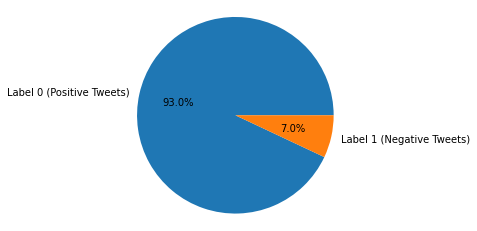

In [13]:
# Class Imbalance Check
plt.pie(y_train.value_counts(), 
        labels=['Label 0 (Positive Tweets)', 'Label 1 (Negative Tweets)'], 
        autopct='%0.1f%%')
plt.axis('equal')
plt.show()

There is a high class imbalance in the dataset. We'll use SMOTE (Synthetic Minority Over-sampling Technique) to balance the class. I tried using the random oversampling technique, but SMOTE generated better predictions, so the same is used ahead.

(47560, 34643) (47560,)
(59440, 40437) (59440,)


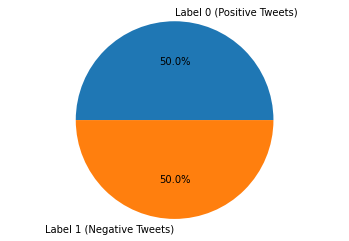

In [14]:
# SMOTE to deal with the class imbalance
smote = SMOTE()
X_train_smote, y_train_smote = smote.fit_resample(X_train_tweets_tfidf, y_train.values)
print(X_train_smote.shape, y_train_smote.shape)

# SMOTE on full training data
smote = SMOTE()
X_smote, y_smote = smote.fit_resample(X_tweets_tfidf, y.values)
print(X_smote.shape, y_smote.shape)

# Class Imbalance Check
plt.pie(pd.value_counts(y_train_smote), 
        labels=['Label 0 (Positive Tweets)', 'Label 1 (Negative Tweets)'], 
        autopct='%0.1f%%')
plt.axis('equal')
plt.show()

# ML Modeling
The evaluation metric used in the competition is F1-Score; therefore, we will try to maximize the same.

In [15]:
# Functions to print scores
def training_scores(y_act, y_pred):
    acc = round(accuracy_score(y_act, y_pred), 3)
    f1 = round(f1_score(y_act, y_pred), 3)
    print(f'Training Scores: Accuracy={acc}, F1-Score={f1}')
    
def validation_scores(y_act, y_pred):
    acc = round(accuracy_score(y_act, y_pred), 3)
    f1 = round(f1_score(y_act, y_pred), 3)
    print(f'Validation Scores: Accuracy={acc}, F1-Score={f1}')

In [16]:
# Logistic Regression
lr = LogisticRegression()
lr.fit(X_train_smote, y_train_smote)
y_train_pred = lr.predict(X_train_smote)
y_test_pred = lr.predict(X_test_tweets_tfidf)
training_scores(y_train_smote, y_train_pred)
validation_scores(y_test, y_test_pred)

Training Scores: Accuracy=0.979, F1-Score=0.98
Validation Scores: Accuracy=0.931, F1-Score=0.624


In [17]:
# Naive Bayes Classifier
mnb = MultinomialNB()
mnb.fit(X_train_smote, y_train_smote)
y_train_pred = mnb.predict(X_train_smote)
y_test_pred = mnb.predict(X_test_tweets_tfidf)
training_scores(y_train_smote, y_train_pred)
validation_scores(y_test, y_test_pred)

Training Scores: Accuracy=0.967, F1-Score=0.967
Validation Scores: Accuracy=0.925, F1-Score=0.615


In [18]:
# Random Forest Classifier
rf = RandomForestClassifier()
rf.fit(X_train_smote, y_train_smote)
y_train_pred = rf.predict(X_train_smote)
y_test_pred = rf.predict(X_test_tweets_tfidf)
training_scores(y_train_smote, y_train_pred)
validation_scores(y_test, y_test_pred)

Training Scores: Accuracy=1.0, F1-Score=1.0
Validation Scores: Accuracy=0.964, F1-Score=0.707


In [19]:
# Extreme Gradient Boosting Classifier
xgb = XGBClassifier(objective='binary:logistic', eval_metric='logloss')
xgb.fit(X_train_smote, y_train_smote)
y_train_pred = xgb.predict(X_train_smote)
y_test_pred = xgb.predict(X_test_tweets_tfidf)
training_scores(y_train_smote, y_train_pred)
validation_scores(y_test, y_test_pred)

Training Scores: Accuracy=0.943, F1-Score=0.941
Validation Scores: Accuracy=0.952, F1-Score=0.639


# Hyperparameter Tuning
Among above 4 classifiers, Random Forest Classifier delivered exceptionally good results. XGBoost stands as the second best model. As we can notice, random forest classifier is suffering overfitting while XGBoost classifier is suffering underfitting. With taking this into account, I applied various combination of hyperparameters for random forest and XGBoost classifiers to reach to the optimal solution.

In [20]:
# Random Forest Classifier
rf = RandomForestClassifier(criterion='entropy', max_samples=0.8, 
                            min_samples_split=10, random_state=0)
rf.fit(X_train_smote, y_train_smote)
y_train_pred = rf.predict(X_train_smote)
y_test_pred = rf.predict(X_test_tweets_tfidf)
training_scores(y_train_smote, y_train_pred)
validation_scores(y_test, y_test_pred)
# Public F1-Score = 0.727

Training Scores: Accuracy=0.999, F1-Score=0.999
Validation Scores: Accuracy=0.962, F1-Score=0.713


In [21]:
# Extreme Gradient Boosting Classifier
xgb = XGBClassifier(objective='binary:logistic', eval_metric='logloss', 
                    learning_rate=0.8, max_depth=20, gamma=0.6, 
                    reg_lambda=0.1, reg_alpha=0.1)
xgb.fit(X_train_smote, y_train_smote)
y_train_pred = xgb.predict(X_train_smote)
y_test_pred = xgb.predict(X_test_tweets_tfidf)
training_scores(y_train_smote, y_train_pred)
validation_scores(y_test, y_test_pred)
# Public F1-Score = 0.692

Training Scores: Accuracy=0.999, F1-Score=0.999
Validation Scores: Accuracy=0.962, F1-Score=0.701


# Prediction Submission

In [22]:
# Predicting test data on full training data
rf = RandomForestClassifier(criterion='entropy', max_samples=0.8, 
                            min_samples_split=10, random_state=0)
rf.fit(X_smote, y_smote)
predictions = rf.predict(test_tweets_tfidf)
submission = pd.DataFrame({'id':test_df.id, 'label':predictions})
submission.head()

,id,label
0,31963,0
1,31964,1
2,31965,0
3,31966,0
4,31967,0


In [23]:
submission.to_csv('Submission.csv', index=False)
print('Submission is successful!')

Submission is successful!
